# Introduction

For this challenge, I will walk you through the steps to build the model. First, let's load the data and look at some basic stats. It is build using a combination of Pyspark, Python and Docker.

Until Variable Selection - Pyspark, some python  
Modeling and Final code - Python   
Docker - complete work is done in Docker and final implementation  

# Parameters that are used in the entire modeling exercise

In [1]:
filename = 'dataset_00_with_header.csv' #name of file
target_variable_name = 'y'

#The columns with missing percentage greater than this value will be dropped. range - (0,1)
missing_percentage = 0.75 

#size of the test dataset as a percentage
test_size = 0.3 

# 1. Load Dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor

from pyspark.sql import SparkSession
from pyspark.ml.feature import Imputer
from pyspark.sql.functions import approxCountDistinct, countDistinct
from pyspark.sql.functions import count, when, isnan, col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol
from pyspark.mllib.stat import Statistics

In [3]:
spark = SparkSession.builder.getOrCreate()
df = spark.read.csv(filename, header=True, inferSchema=True, sep=',')
df.show()

+-------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+------+-----+-----+------+-----+----+----+----+----+----+----+----+----+----+----+----+------+------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----

In [4]:
df.printSchema()

root
 |-- x001: integer (nullable = true)
 |-- x002: integer (nullable = true)
 |-- x003: integer (nullable = true)
 |-- x004: integer (nullable = true)
 |-- x005: integer (nullable = true)
 |-- x006: integer (nullable = true)
 |-- x007: integer (nullable = true)
 |-- x008: integer (nullable = true)
 |-- x009: integer (nullable = true)
 |-- x010: integer (nullable = true)
 |-- x011: integer (nullable = true)
 |-- x012: integer (nullable = true)
 |-- x013: integer (nullable = true)
 |-- x014: integer (nullable = true)
 |-- x015: integer (nullable = true)
 |-- x016: integer (nullable = true)
 |-- x017: integer (nullable = true)
 |-- x018: integer (nullable = true)
 |-- x019: integer (nullable = true)
 |-- x020: integer (nullable = true)
 |-- x021: integer (nullable = true)
 |-- x022: integer (nullable = true)
 |-- x023: integer (nullable = true)
 |-- x024: integer (nullable = true)
 |-- x025: integer (nullable = true)
 |-- x026: integer (nullable = true)
 |-- x027: integer (nullable = tr

Since, all the variables are __continuous__, we will look at some descriptive stats now.

# 2. Descriptive Statistics

In [5]:
df.count()

100000

In [6]:
df.describe().toPandas()

,summary,x001,x002,x003,x004,x005,x006,x007,x008,x009,...,x296,x297,x298,x299,x300,x301,x302,x303,x304,y
0,count,100000,78568,78568,78576,93890,100000,100000,100000,100000,...,100000,41888,100000,100000,100000,100000,26931,100000,18125,100000
1,mean,1218243.8211,125.71172742083291,25.541238163119846,65.3932116676848,178.23854510597508,0.31404,0.694,1.38822,1.19298,...,11819.59612,0.7940342604087104,0.54332,0.55803,0.58183,0.10624,2.9487579369499834,6410.88291,1.0379572579310359,619.19823
2,stddev,272897.72497733554,115.78511663964385,49.028750509510985,63.592316888764074,124.52062788339188,0.4641347138604546,1.3793777679918813,2.282804709906971,2.0310834479655746,...,32264.68893997869,0.2882494471605394,0.49812233322607463,0.49662358527344974,0.49326086826631776,0.308146088633491,2.1294295782534918,24190.24331330001,0.33058024130317254,118.46193180579135
3,min,517,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,1,0,0.0,300
4,max,1677197,718,704,704,827,1,44,108,81,...,2696702,13.0353,1,1,1,1,9,785537,5.1569,839


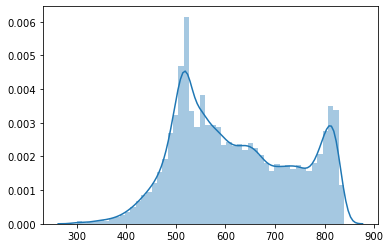

In [7]:
y = df.select(target_variable_name).toPandas()
sns.distplot(y)

The target variable looks like a credit score. The target range is between 300 and 839 and the actual credit score range is between 300 and 850. One more thing to try for the target column would be a quantile tranformation to make it normal. We will use quantile transformation, if our first cut model is not better. A glimpse of quantile tranformation is provided below.

In [8]:
rng = np.random.RandomState(304)
qt_target = QuantileTransformer(n_quantiles=50, output_distribution='normal', random_state=rng)
qt_target.fit(y)
y = qt_target.transform(y)

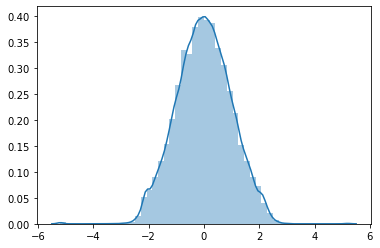

In [9]:
sns.distplot(y)

The quantile tranformation works perfectly as expected. We will use this transformation on target, when our first cut model is not performing well with the actual target.

## 2.1 Check cardinality for each columns

If a column has only one value, then it can be dropped too. Since, it is not useful for prediction. Let's check that now. I am setting the cut_off as 1, so that these variables can be selected separately.

In [10]:
from pyspark.sql.functions import approxCountDistinct, countDistinct

"""
Note: approxCountDistinct and countDistinct can be used interchangeably. Only difference is the computation time. 

"approxCountDistinct" is useful for large datasets 
"countDistinct" for small and medium datasets.

"""

def cardinality_calculation(df, cut_off=1):
    cardinality = df.select(*[countDistinct(c).alias(c) for c in df.columns])
    
    ## convert to pandas for efficient calculations
    final_cardinality_df = cardinality.toPandas().transpose()
    final_cardinality_df.reset_index(inplace=True) 
    final_cardinality_df.rename(columns={0:'Cardinality'}, inplace=True) 
    
    #select variables with cardinality of 1
    vars_selected = final_cardinality_df['index'][final_cardinality_df['Cardinality'] <= cut_off] 
    
    return final_cardinality_df, vars_selected

cardinality_df, cardinality_vars_selected = cardinality_calculation(df)

In [11]:
cardinality_df

,index,Cardinality
0,x001,100000
1,x002,666
2,x003,457
3,x004,492
4,x005,699
...,...,...
300,x301,2
301,x302,7
302,x303,15165
303,x304,8011


In [12]:
cardinality_vars_selected = list(cardinality_vars_selected)
cardinality_vars_selected

['x067', 'x094', 'x095', 'x096']

One more thing to be noticed is, the first column cardinality is equal to the length of the dataset. So it seems to me like an ID column. We will ignore that too.

In [13]:
cardinality_vars_selected.extend(['x001'])

In [14]:
cardinality_vars_selected

['x067', 'x094', 'x095', 'x096', 'x001']

In [15]:
dropped_columns = [] #all dropped columns
dropped_columns.extend(cardinality_vars_selected) #appending to all dropped columns

In [16]:
df = df.drop(*cardinality_vars_selected)

## 2.2 Missing values check

Missing values are another good strategy to drop columns that are not useful for our analysis. If a column has a certain missing value percentage cutoff, then it can be removed. This is set by the miss_percentage function below. I am using 70% for this analysis.

In [17]:
#missing values check
# miss_percentage is set to 70% as discussed in the book
def missing_calculation(df, miss_percentage=0.70):
    
    #checks for both NaN and null values
    missing = df.select(*[count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns])
    length_df = df.count()
    ## convert to pandas for efficient calculations
    final_missing_df = missing.toPandas().transpose()
    final_missing_df.reset_index(inplace=True) 
    final_missing_df.rename(columns={0:'missing_count'}, inplace=True) 
    final_missing_df['missing_percentage'] = final_missing_df['missing_count']/length_df
    
    #select variables with cardinality of 1
    vars_selected = final_missing_df['index'][final_missing_df['missing_percentage'] >= miss_percentage] 
    
    return final_missing_df, vars_selected

In [18]:
missing_df, missing_vars_selected = missing_calculation(df)

In [19]:
missing_df

,index,missing_count,missing_percentage
0,x002,21432,0.21432
1,x003,21432,0.21432
2,x004,21424,0.21424
3,x005,6110,0.06110
4,x006,0,0.00000
...,...,...,...
295,x301,0,0.00000
296,x302,73069,0.73069
297,x303,0,0.00000
298,x304,81875,0.81875


In [20]:
missing_vars_selected

92     x098
149    x155
236    x242
249    x255
250    x256
251    x257
253    x259
289    x295
296    x302
298    x304
Name: index, dtype: object

In [21]:
df = df.drop(*missing_vars_selected)

In [22]:
dropped_columns.extend(missing_vars_selected) #appending to all dropped columns

In [23]:
dropped_columns

['x067',
 'x094',
 'x095',
 'x096',
 'x001',
 'x098',
 'x155',
 'x242',
 'x255',
 'x256',
 'x257',
 'x259',
 'x295',
 'x302',
 'x304']

For other missing columns (41) values, I will impute them with Median for now. 

In [24]:
len(missing_df[missing_df['missing_percentage'] > 0])

41

## 2.3 Train and test split

In [25]:
train, test = df.randomSplit([0.7, 0.3], seed=12345)

In [26]:
train = train.select(*(col(c).cast("double").alias(c) for c in train.columns))
test = test.select(*(col(c).cast("double").alias(c) for c in test.columns))

## 2.4 Median Imputation of other columns

In [27]:
column_names = train.columns

In [28]:
imputer = Imputer(inputCols=column_names, outputCols=column_names)
Median_Imputer = imputer.setStrategy("median").fit(train)

train = Median_Imputer.transform(train)
test = Median_Imputer.transform(test)

# 3. Variable Selection

## 3.1 Assemble vectors

In [29]:
#assemble individual columns to one column - 'features'
def assemble_vectors(df, features_list, target_variable_name):
    stages = []
    #assemble vectors
    assembler = VectorAssembler(inputCols=features_list, outputCol='features')
    stages = [assembler]
    #select all the columns + target + newly created 'features' column
    selectedCols = [target_variable_name, 'features']
    #use pipeline to process sequentially
    pipeline = Pipeline(stages=stages)
    #assembler model
    assembleModel = pipeline.fit(df)
    #apply assembler model on data
    df = assembleModel.transform(df).select(selectedCols)

    return df

In [30]:
#exclude target variable and select all other feature vectors
features_list = train.columns
#features_list = char_vars #this option is used only for ChiSqselector
features_list.remove(target_variable_name)

In [31]:
# apply the function on our dataframe
assembled_train = assemble_vectors(train, features_list, target_variable_name)

In [32]:
for k, v in assembled_train.schema["features"].metadata["ml_attr"]["attrs"].items():
    features_df = pd.DataFrame(v)

## 3.2 Decision Tree based variable selection

In [33]:
dt = DecisionTreeRegressor(featuresCol='features', labelCol=target_variable_name)
dt_model = dt.fit(assembled_train)

In [34]:
dt_output = dt_model.featureImportances
features_df['Decision Tree'] = features_df['idx'].apply(lambda x: dt_output[x] if x in dt_output.indices else 0)

In [35]:
#sort values based on descending importance feature
features_df.sort_values("Decision Tree", ascending=False, inplace=True)

In [36]:
features_df

,idx,name,Decision Tree
41,41,x043,0.615029
55,55,x057,0.097727
72,72,x075,0.086882
261,261,x274,0.082543
268,268,x281,0.028984
...,...,...,...
108,108,x115,0.000000
109,109,x116,0.000000
110,110,x117,0.000000
111,111,x118,0.000000


## 3.3 Gradient boosting based variable selection

In [37]:
gb = GBTRegressor(featuresCol='features', labelCol=target_variable_name)
gb_model = gb.fit(assembled_train)

In [38]:
gb_output = gb_model.featureImportances
features_df['Gradient Boosting'] = features_df['idx'].apply(lambda x: gb_output[x] if x in gb_output.indices else 0)

In [39]:
features_df.sort_values("Gradient Boosting", ascending=False, inplace=True)

In [40]:
features_df

,idx,name,Decision Tree,Gradient Boosting
41,41,x043,0.615029,0.097198
55,55,x057,0.097727,0.076012
3,3,x005,0.002180,0.053593
72,72,x075,0.086882,0.053507
34,34,x036,0.000000,0.048812
...,...,...,...,...
149,149,x157,0.000000,0.000000
48,48,x050,0.000000,0.000000
51,51,x053,0.000000,0.000000
199,199,x207,0.000000,0.000000


## 3.4 Random Forest based variable selection

In [41]:
rf = RandomForestRegressor(featuresCol='features', labelCol=target_variable_name)
rf_model = rf.fit(assembled_train)

In [42]:
rf_output = rf_model.featureImportances
features_df['Random Forest'] = features_df['idx'].apply(lambda x: rf_output[x] if x in rf_output.indices else 0)

In [43]:
features_df.sort_values("Random Forest", ascending=False, inplace=True)

In [44]:
features_df

,idx,name,Decision Tree,Gradient Boosting,Random Forest
41,41,x043,0.615029,0.097198,0.169595
228,228,x236,0.004321,0.012368,0.142632
227,227,x235,0.021850,0.016237,0.128120
42,42,x044,0.004193,0.001615,0.098404
57,57,x059,0.002178,0.023640,0.061191
...,...,...,...,...,...
135,135,x142,0.000000,0.000000,0.000000
80,80,x083,0.000000,0.000000,0.000000
82,82,x085,0.000000,0.000000,0.000000
86,86,x089,0.000000,0.000000,0.000000


## 3.5 Voting based variable selection

In [45]:
features_df.drop('idx', axis=1, inplace=True)

In [46]:
num_top_features = 25
columns = ['Decision Tree', 'Gradient Boosting', 'Random Forest']
score_table = pd.DataFrame({},[])
score_table['name'] = features_df['name']
for i in columns:
    score_table[i] = features_df['name'].isin(list(features_df.nlargest(num_top_features,i)['name'])).astype(int)

In [47]:
score_table['final_score'] = score_table.sum(axis=1)
score_table.sort_values('final_score',ascending=0)

,name,Decision Tree,Gradient Boosting,Random Forest,final_score
41,x043,1,1,1,3
55,x057,1,1,1,3
3,x005,1,1,1,3
268,x281,1,1,1,3
92,x099,1,1,1,3
...,...,...,...,...,...
204,x212,0,0,0,0
75,x078,0,0,0,0
148,x156,0,0,0,0
190,x198,0,0,0,0


In [48]:
len(score_table[score_table['final_score'] > 0]['name'])

45

In [49]:
len(score_table[score_table['final_score'] > 1]['name'])

20

In [50]:
len(score_table[score_table['final_score'] == 3]['name'])

10

Finally, with voting based selection, I combined the votes obtained by individual variables with a variety of feature selection technique and choosing the best features. You can extend the number of selection techniques here. I will using only 3 for this example.

Final number of features:  

If atleast one algorithm, picked a variable
```python
len(score_table[score_table['final_score'] > 0]['name'])
```
   
If atleast two algorithm, picked a variable
```python
len(score_table[score_table['final_score'] > 1]['name'])
```

If all algorithms, picked a variable
```python
len(score_table[score_table['final_score'] == 3]['name'])
```

## 3.6 Correlation check on input columns

Sometimes people are interested in checking the correlation between columns. Let us look at that output too.

In [51]:
# Import the estimator and transformer class
from pyspark.ml import Transformer
# Parameter sharing class. We will use this for input column
from pyspark.ml.param.shared import HasInputCol
# Statistics class to calculate correlation
from pyspark.mllib.stat import Statistics
import pandas as pd

# custom class definition
class CustomCorrelation(Transformer, HasInputCol):
    """
    A custom function to calculate the correlation between two variables.
    
    Parameters:
    -----------
    inputCol: default value (None)
        Feature column name to be used for the correlation purpose. The input column should be assembled vector.
        
    correlation_type: 'pearson' or 'spearman'
    
    correlation_cutoff: float, default value (0.7), accepted values 0 to 1
        Columns more than the specified cutoff will be displayed in the shortlisted output dataframe. 
    """
    
    # Initialize parameters for the function
    def __init__(self, inputCol=None, correlation_type='pearson', correlation_cutoff=0.7):
        
        super(CustomCorrelation, self).__init__()
        
        assert inputCol, "Please provide a assembled feature column name"
        #self.inputCol is class parameter
        self.inputCol = inputCol 
        
        assert correlation_type == 'pearson' or correlation_type == 'spearman', "Please provide a valid option for correlation type. 'pearson' or 'spearman'. "
        #self.correlation_type is class parameter
        self.correlation_type = correlation_type
        
        assert 0.0 <= correlation_cutoff <= 1.0, "Provide a valid value for cutoff. Accepted range is 0 to 1" 
        #self.correlation_cutoff is class parameter
        self.correlation_cutoff = correlation_cutoff
            
    # Transformer function, method inside a class, '_transform' - protected parameter
    def _transform(self, df):
        
        for k, v in df.schema[self.inputCol].metadata["ml_attr"]["attrs"].items():
            features_df = pd.DataFrame(v)
            
        column_names = list(features_df['name'])
        df_vector = df.rdd.map(lambda x: x[self.inputCol].toArray())
        
        #self.correlation_type is class parameter
        matrix = Statistics.corr(df_vector, method=self.correlation_type)
        
        # apply pandas dataframe operation on the fit output
        corr_df = pd.DataFrame(matrix, columns=column_names, index=column_names)
        final_corr_df = pd.DataFrame(corr_df.abs().unstack().sort_values(kind='quicksort')).reset_index()
        final_corr_df.rename({'level_0': 'col1', 'level_1': 'col2', 0: 'correlation_value'}, axis=1, inplace=True)
        final_corr_df = final_corr_df[final_corr_df['col1'] != final_corr_df['col2']]

        #shortlisted dataframe based on custom cutoff
        shortlisted_corr_df = final_corr_df[final_corr_df['correlation_value'] > 0.7]
        temp_df = pd.DataFrame(np.sort(shortlisted_corr_df[['col1','col2']].values, axis=1), columns=['col1', 'col2'])
        shortlisted_corr_df.loc[:,'col1'] = list(temp_df['col1'])
        shortlisted_corr_df.loc[:,'col2'] = list(temp_df['col2'])
        shortlisted_corr_df = shortlisted_corr_df.drop_duplicates()
        return corr_df, shortlisted_corr_df

In [52]:
corr_clf = CustomCorrelation(inputCol='features')
output, shorlisted_output = corr_clf.transform(assembled_train)

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [53]:
output

,x002,x003,x004,x005,x006,x007,x008,x009,x010,x011,...,x292,x293,x294,x296,x297,x298,x299,x300,x301,x303
x002,1.000000,0.310878,0.834701,0.718026,0.110699,-0.096406,-0.119875,-0.054850,0.000510,0.064204,...,0.220481,-0.129965,-0.008922,0.078038,-0.148707,-0.071274,-0.072165,-0.070691,-0.072343,0.023507
x003,0.310878,1.000000,0.711579,0.249317,0.208506,-0.207125,-0.229595,-0.156504,-0.119199,-0.098453,...,-0.047249,0.025280,-0.005789,-0.101961,0.003140,-0.186172,-0.185276,-0.178751,-0.008172,-0.037769
x004,0.834701,0.711579,1.000000,0.613806,0.203334,-0.224921,-0.262829,-0.170893,-0.104414,-0.037856,...,0.110440,-0.064473,-0.003899,-0.021009,-0.091265,-0.176648,-0.176146,-0.170479,-0.048461,-0.001633
x005,0.718026,0.249317,0.613806,1.000000,0.132155,-0.046098,-0.060336,-0.014722,0.033214,0.105364,...,0.208286,-0.163720,-0.020899,0.071305,-0.168928,-0.049665,-0.051984,-0.050463,-0.091262,-0.005447
x006,0.110699,0.208506,0.203334,0.132155,1.000000,-0.128121,-0.113031,-0.006302,0.028481,0.059194,...,0.024558,-0.022747,0.019491,-0.015972,-0.018265,-0.004013,-0.002425,0.002580,-0.003119,-0.006634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
x298,-0.071274,-0.186172,-0.176648,-0.049665,-0.004013,0.217444,0.273724,0.283890,0.275705,0.286341,...,0.142646,-0.097267,0.191064,0.333593,-0.114357,1.000000,0.970008,0.924955,0.146781,0.240622
x299,-0.072165,-0.185276,-0.176146,-0.051984,-0.002425,0.214033,0.271972,0.284787,0.277405,0.288425,...,0.141545,-0.092836,0.186010,0.324849,-0.109274,0.970008,1.000000,0.953554,0.150810,0.233760
x300,-0.070691,-0.178751,-0.170479,-0.050463,0.002580,0.205909,0.265299,0.283689,0.277327,0.290411,...,0.141912,-0.089427,0.177730,0.310253,-0.104810,0.924955,0.953554,1.000000,0.157669,0.223095
x301,-0.072343,-0.008172,-0.048461,-0.091262,-0.003119,0.004847,0.009859,0.017310,0.023869,0.077633,...,-0.023347,0.201977,0.221063,0.085485,0.126709,0.146781,0.150810,0.157669,1.000000,0.256791


In [54]:
shorlisted_output

,col1,col2,correlation_value
81576,x250,x262,0.700119
81578,x130,x210,0.700205
81580,x141,x215,0.700552
81582,x028,x249,0.701079
81584,x119,x209,0.701292
...,...,...,...
83222,x206,x216,0.990275
83224,x222,x223,0.992561
83226,x111,x121,0.994664
83228,x273,x279,0.997369


As we can see, in the original input columns we have 828 unique pairs of columns exhibiting a strong correlation. Now let us look at the same for our selected set of features. 

## 2.7 Correlation based removal

In [55]:
selected_atleastone = list(score_table[score_table['final_score'] > 0]['name'])
selected_atleasttwo = list(score_table[score_table['final_score'] > 1]['name'])
selected_all = list(score_table[score_table['final_score'] > 2]['name'])

In [56]:
def correlation_based_removal(output, list_to_use):
    output1 = output.copy(deep=True)
    output1 = output1[output1.index.isin(list_to_use)]
    output1 = output1[list_to_use]
    final_corr_df = pd.DataFrame(output1.abs().unstack().sort_values(kind='quicksort')).reset_index()
    final_corr_df.rename({'level_0': 'col1', 'level_1': 'col2', 0: 'correlation_value'}, axis=1, inplace=True)
    final_corr_df = final_corr_df[final_corr_df['col1'] != final_corr_df['col2']]

    #shortlisted dataframe based on custom cutoff
    shortlisted_corr_df = final_corr_df[final_corr_df['correlation_value'] > 0.7]
    temp_df = pd.DataFrame(np.sort(shortlisted_corr_df[['col1','col2']].values, axis=1), columns=['col1', 'col2'])
    shortlisted_corr_df.loc[:,'col1'] = list(temp_df['col1'])
    shortlisted_corr_df.loc[:,'col2'] = list(temp_df['col2'])
    shortlisted_corr_df = shortlisted_corr_df.drop_duplicates()
    return shortlisted_corr_df

In [57]:
def which_is_greater(df):
    
    if df['RF1'] > df['RF2']:
        return df['col1']
    else:
        return df['col2']
    
def which_is_loser(df):
    
    if df['RF1'] < df['RF2']:
        return df['col1']
    else:
        return df['col2']

In [58]:
def append_rf_scores(shortlisted_corr_df, features_df):
    
    shortlisted_corr_df['RF1'] = shortlisted_corr_df['col1'].apply(lambda x: features_df[features_df['name'] == x]['Random Forest'].iloc[0])
    shortlisted_corr_df['RF2'] = shortlisted_corr_df['col2'].apply(lambda x: features_df[features_df['name'] == x]['Random Forest'].iloc[0])
    shortlisted_corr_df['winner'] = shortlisted_corr_df.apply(which_is_greater, axis=1)
    shortlisted_corr_df['loser'] = shortlisted_corr_df.apply(which_is_loser, axis=1)
    return shortlisted_corr_df

In [59]:
shortlisted_corr_df = correlation_based_removal(output, selected_atleastone)
shortlisted_corr_df = append_rf_scores(shortlisted_corr_df, features_df)

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [60]:
shortlisted_corr_df

,col1,col2,correlation_value,RF1,RF2,winner,loser
1938,x014,x017,0.709023,0.002516,0.000065,x014,x017
1940,x021,x225,0.715689,0.001715,0.027716,x225,x021
1942,x225,x236,0.719436,0.027716,0.142632,x236,x225
1944,x192,x278,0.744740,0.000733,0.005868,x278,x192
1946,x119,x193,0.744804,0.000000,0.002192,x193,x119
1948,x235,x236,0.746263,0.128120,0.142632,x236,x235
1950,x226,x236,0.774151,0.057913,0.142632,x236,x226
1952,x119,x194,0.789806,0.000000,0.000383,x194,x119
1954,x041,x057,0.814120,0.019194,0.055301,x057,x041
1956,x193,x194,0.819298,0.002192,0.000383,x193,x194


__Selected by atleast one algorithm:__   

When I use the variables selected by atleast one algorithm, then I see that atleast 22 unique pairs of columns are strongly correlated. So, we will remove the loser variables based on Random Forest feature importance. 

In [61]:
removal_list_vars = np.unique(list(shortlisted_corr_df['loser'])) #final list of features removed based on correlation

In [62]:
removal_list_vars

array(['x017', 'x021', 'x041', 'x065', 'x099', 'x119', 'x170', 'x192',
       'x194', 'x225', 'x226', 'x233', 'x235', 'x277', 'x278'],
      dtype='<U4')

In [63]:
selected_atleastone = list(set(selected_atleastone).difference(set(removal_list_vars))) #uncorrelated vars
selected_atleasttwo = list(set(selected_atleasttwo).difference(set(removal_list_vars))) #uncorrelated vars
selected_all = list(set(selected_all).difference(set(removal_list_vars)))

In [64]:
len(selected_atleastone), len(selected_atleasttwo), len(selected_all)

(30, 14, 8)

Now, we have 27 features that are selected by atleast one algorithm using our techniques before. Now, we will export these columns to a csv file. From this point on, we can continue using Pyspark. However, I would like to try using XGBoost which is available in Python. 

In [65]:
selected_atleastone.extend(target_variable_name)
df = df.select(selected_atleastone)
df.coalesce(1).write.mode('overwrite').option("header", "true").option("delimiter", ",").csv("subset_data.csv")

Okay cool. We have a dataset now. Let us proceed a step further and build a model in Pyspark. We will use python later.

In [66]:
selected_atleastone.pop()

'y'

# 4. Pyspark model building

In [96]:
# apply the function on our dataframe
subset_train = assemble_vectors(train, selected_atleastone, target_variable_name)
subset_test = assemble_vectors(test, selected_atleastone, target_variable_name)

for k, v in subset_train.schema["features"].metadata["ml_attr"]["attrs"].items():
    sub_features_df = pd.DataFrame(v)

In [97]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import functions as F

def accuracy_calculation(df):
    
    df = df.withColumn("diff", F.abs(F.col("y") - F.col("prediction")))
    df = df.withColumn('correct_prediction', F.when(F.col("diff") <= 3, 1).otherwise(0))
    accuracy = df.agg(F.avg('correct_prediction').alias('accuracy')).toPandas()['accuracy'][0]
    return accuracy

def pyspark_model_evaluator(pred_train, pred_test):
    
    #rmse evaluation
    rmse_evaluator = RegressionEvaluator(metricName="rmse", labelCol=target_variable_name)
    rmse_train = rmse_evaluator.evaluate(pred_train)
    rmse_test = rmse_evaluator.evaluate(pred_test)
    
    #accuracy evaluation
    acc_train = accuracy_calculation(pred_train)
    acc_test = accuracy_calculation(pred_test)
    
    #r squared evaluation
    r2_evaluator = RegressionEvaluator(metricName="r2", labelCol=target_variable_name)
    r2_train = r2_evaluator.evaluate(pred_train)
    r2_test = r2_evaluator.evaluate(pred_test)

    return rmse_train, rmse_test, acc_train, acc_test, r2_train, r2_test

## 4.1 Random Forest Pyspark

In [98]:
rf = RandomForestRegressor(featuresCol='features', labelCol=target_variable_name)
rf_model = rf.fit(subset_train)

In [99]:
pred_train = rf_model.transform(subset_train).select(['y', 'prediction'])
pred_test = rf_model.transform(subset_test).select(['y', 'prediction'])

In [100]:
rmse_train, rmse_test, acc_train, acc_test, r2_train, r2_test = pyspark_model_evaluator(pred_train, pred_test)

In [101]:
print("Train RMSE - ", rmse_train)
print("Test RMSE - ", rmse_test)
print("\n")
print("Train Accuracy - ", acc_train)
print("Test Accuracy - ", acc_test)
print("\n")
print("Train R squared - ", r2_train)
print("Test R squared - ", r2_test)

Train RMSE -  44.11801575774094
Test RMSE -  44.7891266075008


Train Accuracy -  0.06252325481553565
Test Accuracy -  0.061715689529247726


Train R squared -  0.8609916516593015
Test R squared -  0.8577487422906241


This is a start. Now, our goal is to build models that can improve our results further. I will try one more model - Gradient boosting.

## 4.2 Gradient Boosting Pyspark

In [102]:
gb = GBTRegressor(featuresCol='features', labelCol=target_variable_name)
gb_model = gb.fit(subset_train)

In [103]:
pred_train = gb_model.transform(subset_train).select(['y', 'prediction'])
pred_test = gb_model.transform(subset_test).select(['y', 'prediction'])

In [104]:
rmse_train, rmse_test, acc_train, acc_test, r2_train, r2_test = pyspark_model_evaluator(pred_train, pred_test)

In [105]:
print("Train RMSE - ", rmse_train)
print("Test RMSE - ", rmse_test)
print("\n")
print("Train Accuracy - ", acc_train)
print("Test Accuracy - ", acc_test)
print("\n")
print("Train R squared - ", r2_train)
print("Test R squared - ", r2_test)

Train RMSE -  37.56160322020801
Test RMSE -  38.62430704575396


Train Accuracy -  0.09560949082686969
Test Accuracy -  0.09620875107894562


Train R squared -  0.8992379065920377
Test R squared -  0.8942129931923527


Looks like our model improved a little bit. But still, the accuracy is not great. Okay, from here on I would like to switch to Python and try some Python based models.

## 4.3 Linear regression Pyspark

In [106]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol='features', labelCol=target_variable_name)
lr_model = lr.fit(subset_train)

In [107]:
pred_train = lr_model.transform(subset_train).select(['y', 'prediction'])
pred_test = lr_model.transform(subset_test).select(['y', 'prediction'])

In [108]:
rmse_train, rmse_test, acc_train, acc_test, r2_train, r2_test = pyspark_model_evaluator(pred_train, pred_test)

In [109]:
print("Train RMSE - ", rmse_train)
print("Test RMSE - ", rmse_test)
print("\n")
print("Train Accuracy - ", acc_train)
print("Test Accuracy - ", acc_test)
print("\n")
print("Train R squared - ", r2_train)
print("Test R squared - ", r2_test)

Train RMSE -  56.819752640318676
Test RMSE -  56.810879577566666


Train Accuracy -  0.04304645238844844
Test Accuracy -  0.044784542859039905


Train R squared -  0.7694274419995126
Test R squared -  0.7711378602654071


# 5. Python based model building

At this point, I want to move to Python and start experimenting with Python. 

In [4]:
df = pd.read_csv('subset_data.csv/part-00000-03fb537b-9382-4a5b-bac8-26d245ab88ab-c000.csv')

In [5]:
df.head()

,x005,x276,x056,x193,x171,x075,x275,x281,x236,x057,...,x059,x055,x076,x274,x239,x245,x287,x014,x003,y
0,8.0,0,0,0,0,0,NaN,0,0,NaN,...,0,0,0,0,NaN,1,NaN,0,NaN,706
1,4.0,0,0,0,0,22375,NaN,5206,0,NaN,...,8,0,0,0,NaN,0,1.0,0,3.0,558
2,96.0,0,2,0,0,3287,0.4814,0,0,NaN,...,3,0,1,1613,NaN,1,NaN,0,NaN,577
3,258.0,1,2,8,0,684,1.1153,0,-156,1.52,...,5,0,1,4796,14.0,1,2.0,1,14.0,526
4,34.0,1,0,1,1,2810,0.1430,0,710,0.62,...,7,0,0,186,29.5,1,NaN,0,25.0,496


## 5.1 Train, Test split

In [6]:
features = df[df.columns.difference(['y'])]
target = df.y

In [7]:
target.describe()

count    100000.000000
mean        619.198230
std         118.461932
min         300.000000
25%         524.000000
50%         599.000000
75%         720.000000
max         839.000000
Name: y, dtype: float64

In [8]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=test_size, random_state=12345)

In [9]:
y_train = np.array(y_train).reshape(y_train.size, 1)
y_test = np.array(y_test).reshape(y_test.size, 1)

## 5.2 Median imputation for input variables

We will perform median imputation as we did before in Pyspark for the selected columns.

In [10]:
pd.DataFrame(y_train).describe()

,0
count,70000.000000
mean,619.245157
std,118.591229
min,300.000000
25%,523.000000
50%,599.000000
75%,720.000000
max,839.000000


In [11]:
pd.DataFrame(y_test).describe()

,0
count,30000.000000
mean,619.088733
std,118.161590
min,300.000000
25%,524.000000
50%,599.000000
75%,719.000000
max,839.000000


In [12]:
median_values = X_train.median()

In [13]:
imputed_X_train = X_train.fillna(median_values)
imputed_X_test = X_test.fillna(median_values)

In [14]:
imputed_X_train.head()

,x003,x005,x014,x036,x043,x044,x055,x056,x057,x059,...,x243,x245,x272,x274,x275,x276,x281,x287,x293,x296
82494,28.0,196.0,7,1,14056,25000.0,0,0,0.1731,1,...,0,1,0.2841,0,0.5559,0,180153,1.0,0.6303,40401
16315,8.0,150.0,0,4,0,6000.0,0,0,0.7399,0,...,0,0,0.2873,0,0.5559,0,0,1.0,0.8589,0
82824,8.0,453.0,3,0,0,24600.0,0,0,0.7399,0,...,0,1,0.1040,6890,0.5604,0,0,9.0,0.8589,0
58259,19.0,126.0,1,5,-24,600.0,0,2,1.0533,2,...,924,1,0.2374,1229,1.0199,2,1713,1.0,0.2210,1713
5464,8.0,6.0,0,5,0,300.0,0,2,0.7399,2,...,0,1,1.7066,1024,1.7066,0,0,1.0,0.8589,0


## 5.3 Variable transformation - Target & Inputs

The target variable distribution (y) as we seen before, shows a normal distribution after Quantile transformation. We will use it now to have a transformed y.

In [15]:
rng = np.random.RandomState(304)
qt_target = QuantileTransformer(n_quantiles=50, output_distribution='normal', random_state=rng)

In [16]:
rng = np.random.RandomState(304)
qt_target = QuantileTransformer(n_quantiles=50, output_distribution='normal', random_state=rng)
qt_target.fit(y_train)
transformed_y_train = qt_target.transform(y_train)
transformed_y_test = qt_target.transform(y_test)

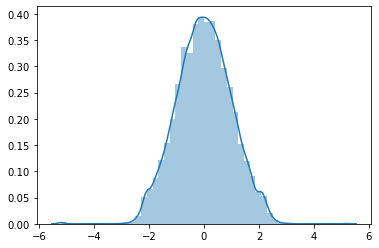

In [17]:
sns.distplot(transformed_y_train)

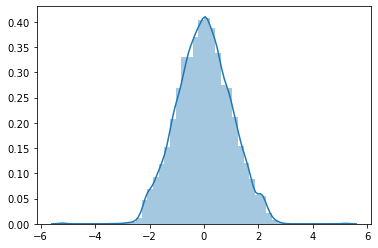

In [18]:
sns.distplot(transformed_y_test)

Looks like the distribution is normal for the target variable after quantile transformation. That's perfect. The mean of the distribution is 0 and the standard deviation is approximately 1. I will do the same transformation for input data too. The code is shown below.

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(imputed_X_train)
X_train = pd.DataFrame(scaler.transform(imputed_X_train), columns=imputed_X_train.columns)
X_test = pd.DataFrame(scaler.transform(imputed_X_test), columns=imputed_X_test.columns)

## 5.4.1 - Variance Inflation factor

In [20]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [37]:
def calculate_vif(features):
    vif = pd.DataFrame()
    vif["Features"] = features.columns
    vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]    
    return(vif)

In [38]:
calculate_vif(X_train)

,Features,VIF
0,x003,1.498958
1,x005,2.326036
2,x014,2.177404
3,x036,1.299423
4,x043,1.973200
5,x044,1.475938
6,x055,1.264592
7,x056,2.414947
8,x057,1.582094
9,x059,1.767012


Looks like the VIF of variables is less than 10. So, we are good with that. 

## 5.4.2 - Model Evaluation metrics helper functions

For the modeling portion, I am going to build two versions of the same model, one with regular target and one with transformed target and compare which one is better for the same version. Let us write some helper functions to perform such kind of analysis.

In [21]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt 

# define model evaluation rmse function
def rmse(y, pred):
    rmse = sqrt(mean_squared_error(y, pred))
    return rmse

# define accuracy evaluation function
def accuracy(y, pred):
    accuracy = (np.abs(y - pred) <= 3).astype(int)
    return np.sum(accuracy)/len(accuracy)

# define model fit function
def model_fit(reg, X_train, X_test, y_tr, y_te, model_name, model_type='regular'):
    
    reg.fit(X_train, y_tr.ravel())

    #prediction results
    pred_train = reg.predict(X_train)
    pred_test = reg.predict(X_test)
    
    if model_type == 'regular':
        pass
    else:
        #reshape values
        pred_train = np.array(pred_train).reshape(pred_train.size, 1)
        pred_test = np.array(pred_test).reshape(pred_test.size, 1)
        
        #quantile remap values
        pred_train = qt_target.inverse_transform(pred_train)
        pred_test = qt_target.inverse_transform(pred_test)
    
    pred_train = pred_train.ravel()
    pred_test = pred_test.ravel()
    pred_train[pred_train > 850] = 850
    pred_test[pred_test > 850] = 850
    pred_train[pred_train < 300] = 300
    pred_test[pred_test < 300] = 300
        
    temp_y_train = y_train.ravel()
    temp_y_test = y_test.ravel()
    
    rmse_train = rmse(temp_y_train, pred_train)
    rmse_test = rmse(temp_y_test, pred_test)
    acc_train = accuracy(temp_y_train, pred_train)
    acc_test = accuracy(temp_y_test, pred_test)
    r2_train = r2_score(temp_y_train, pred_train)
    r2_test = r2_score(temp_y_test, pred_test)
    
    print("Target " + str(model_name) + "\n")
    print("Train RMSE - ", rmse_train)
    print("Test RMSE - ", rmse_test)
    print("\n")
    print("Train Accuracy - ", acc_train)
    print("Test Accuracy - ", acc_test)
    print("\n")
    print("Train R squared - ", r2_train)
    print("Test R squared - ", r2_test)

    return rmse_train, rmse_test, acc_train, acc_test, r2_train, r2_test

## 5.4 Random Forest model

In [61]:
from sklearn.ensemble import RandomForestRegressor

reg_randomforest = RandomForestRegressor()

In [41]:
rmse_train, rmse_test, acc_train, acc_test, r2_train, r2_test = model_fit(reg_randomforest, 
                                                                          X_train, 
                                                                          X_test,
                                                                          y_train,
                                                                          y_test,
                                                                          'rf_regular', 
                                                                          model_type='regular')

Target rf_regular

Train RMSE -  11.449381838499022
Test RMSE -  30.52484136512113


Train Accuracy -  0.3275142857142857
Test Accuracy -  0.14363333333333334


Train R squared -  0.9906789433620206
Test R squared -  0.9332626969975808


In [42]:
rmse_train, rmse_test, acc_train, acc_test, r2_train, r2_test = model_fit(reg_randomforest, 
                                                                          X_train, 
                                                                          X_test,
                                                                          transformed_y_train,
                                                                          transformed_y_test,
                                                                          'rf_transformed', 
                                                                          model_type='transformed')

Target rf_transformed

Train RMSE -  12.259851419679515
Test RMSE -  30.817872893443642


Train Accuracy -  0.3345
Test Accuracy -  0.14906666666666665


Train R squared -  0.9893126143284012
Test R squared -  0.931975220946409


## 5.5 Gradient Boosting model

In [43]:
from sklearn.ensemble import GradientBoostingRegressor

reg_GBT = GradientBoostingRegressor()

In [44]:
rmse_train, rmse_test, acc_train, acc_test, r2_train, r2_test = model_fit(reg_GBT, 
                                                                          X_train, 
                                                                          X_test,
                                                                          y_train,
                                                                          y_test,
                                                                          'rf_regular', 
                                                                          model_type='regular')

Target rf_regular

Train RMSE -  33.107320538794006
Test RMSE -  33.01533313149125


Train Accuracy -  0.09918571428571428
Test Accuracy -  0.0965


Train R squared -  0.9220620218352366
Test R squared -  0.9219283805405724


In [45]:
rmse_train, rmse_test, acc_train, acc_test, r2_train, r2_test = model_fit(reg_GBT, 
                                                                          X_train, 
                                                                          X_test,
                                                                          transformed_y_train,
                                                                          transformed_y_test,
                                                                          'rf_transformed', 
                                                                          model_type='transformed')

Target rf_transformed

Train RMSE -  34.34889697708946
Test RMSE -  34.28610659682718


Train Accuracy -  0.1055
Test Accuracy -  0.10456666666666667


Train R squared -  0.916106819583497
Test R squared -  0.9158027004355356


## 5.6 XGBoost

In [62]:
import xgboost as xgb

xg_model = xgb.XGBRegressor()

In [63]:
rmse_train, rmse_test, acc_train, acc_test, r2_train, r2_test = model_fit(xg_model, 
                                                                          X_train, 
                                                                          X_test,
                                                                          y_train,
                                                                          y_test,
                                                                          'rf_regular', 
                                                                          model_type='regular')

Target rf_regular

Train RMSE -  25.749922203581587
Test RMSE -  30.302877309324774


Train Accuracy -  0.13428571428571429
Test Accuracy -  0.12433333333333334


Train R squared -  0.9528531251465733
Test R squared -  0.9342297404774029


In [64]:
rmse_train, rmse_test, acc_train, acc_test, r2_train, r2_test = model_fit(xg_model, 
                                                                          X_train, 
                                                                          X_test,
                                                                          transformed_y_train,
                                                                          transformed_y_test,
                                                                          'rf_transformed', 
                                                                          model_type='transformed')

Target rf_transformed

Train RMSE -  26.858767751395956
Test RMSE -  30.94112739762827


Train Accuracy -  0.13937142857142856
Test Accuracy -  0.12663333333333332


Train R squared -  0.9487052123977827
Test R squared -  0.9314300096105335


## 5.7 Neural Networks

In [49]:
from sklearn.neural_network import MLPRegressor

nn_model = MLPRegressor()

In [51]:
rmse_train, rmse_test, acc_train, acc_test, r2_train, r2_test = model_fit(nn_model, 
                                                                          X_train, 
                                                                          X_test,
                                                                          y_train,
                                                                          y_test,
                                                                          'rf_regular', 
                                                                          model_type='regular')

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Target rf_regular

Train RMSE -  32.49753586221267
Test RMSE -  33.81108284808926


Train Accuracy -  0.09484285714285715
Test Accuracy -  0.09423333333333334


Train R squared -  0.9249065717831915
Test R squared -  0.9181195953221063


## 5.8 Stacking Regressor

In [22]:
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.ensemble import StackingRegressor

In [24]:
final_layer = StackingRegressor(estimators=[('rf', RandomForestRegressor(random_state=42)),
                                            ('gbrt', GradientBoostingRegressor(random_state=42))],
                                final_estimator=RidgeCV())
multi_layer_regressor = StackingRegressor(estimators=[('ridge', RidgeCV()),
                                                      ('lasso', LassoCV(random_state=42)),
                                                      ('svr', SVR(C=1, gamma=1e-6, kernel='rbf'))],
                                          final_estimator=final_layer)
multi_layer_regressor.fit(X_train, y_train.ravel())

StackingRegressor(cv=None,
                  estimators=[('ridge',
                               RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                       cv=None, fit_intercept=True,
                                       gcv_mode=None, normalize=False,
                                       scoring=None, store_cv_values=False)),
                              ('lasso',
                               LassoCV(alphas=None, copy_X=True, cv=None,
                                       eps=0.001, fit_intercept=True,
                                       max_iter=1000, n_alphas=100, n_jobs=None,
                                       normalize=False, positive=False,
                                       precompute='auto', random_s...
                                                                                           n_iter_no_change=None,
                                                                                           presort='deprecated',
         

In [25]:
pred_train = multi_layer_regressor.predict(X_train)
pred_test = multi_layer_regressor.predict(X_test)

In [30]:
print("Target " + str("Keras regular") + "\n")
print("Train RMSE - ", rmse(y_train.ravel(), pred_train.ravel()))
print("Test RMSE - ", rmse(y_test.ravel(), pred_test.ravel()))
print("\n")
print("Train Accuracy - ", accuracy(y_train.ravel(), pred_train.ravel()))
print("Test Accuracy - ", accuracy(y_test.ravel(), pred_test.ravel()))
print("\n")
print("Train R squared - ", r2_score(y_train.ravel(), pred_train.ravel()))
print("Test R squared - ", r2_score(y_test.ravel(), pred_test.ravel()))

Target Keras regular

Train RMSE -  50.78442352829841
Test RMSE -  50.73020325883116


Train Accuracy -  0.0607
Test Accuracy -  0.060366666666666666


Train R squared -  0.8166157125695096
Test R squared -  0.8156704234447933


## 5.9 Deep learning model - Keras

In [33]:
from keras.layers import Dense, Dropout
from keras.models import Sequential
import tensorflow as tf

def define_model(n_input):
    # define model
    model = Sequential()
    
    # define first layer
    model.add(Dense(30, input_dim=n_input, activation='relu', kernel_initializer='normal'))
    model.add(Dropout(0.5))
    
    # define second layer
    model.add(Dense(20, activation='relu'))
    model.add(Dropout(0.5))
    
    # define second layer
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(0.5))
    
    # define second layer
    model.add(Dense(5, activation='relu'))
    model.add(Dropout(0.5))
    
    # define output layer
    model.add(Dense(1, activation='linear'))
    # define loss and optimizer
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

In [34]:
n_input = imputed_X_train.shape[1]

In [35]:
n_input

30

In [36]:
model = define_model(n_input)

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                930       
_________________________________________________________________
dropout (Dropout)            (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                620       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 5

In [38]:
model.fit(X_train, y_train, epochs=15, verbose=1)

Epoch 1/15
2188/2188 [==============================] - 3s 1ms/step - loss: 177225.0938 - root_mean_squared_error: 420.9811
Epoch 2/15
2188/2188 [==============================] - 3s 1ms/step - loss: 133534.2812 - root_mean_squared_error: 365.4234
Epoch 3/15
2188/2188 [==============================] - 3s 1ms/step - loss: 125667.8828 - root_mean_squared_error: 354.4967
Epoch 4/15
2188/2188 [==============================] - 3s 1ms/step - loss: 119132.5938 - root_mean_squared_error: 345.1559
Epoch 5/15
2188/2188 [==============================] - 3s 1ms/step - loss: 115330.7578 - root_mean_squared_error: 339.6038
Epoch 6/15
2188/2188 [==============================] - 3s 1ms/step - loss: 111146.9297 - root_mean_squared_error: 333.3871
Epoch 7/15
2188/2188 [==============================] - 3s 1ms/step - loss: 107363.4062 - root_mean_squared_error: 327.6635
Epoch 8/15
2188/2188 [==============================] - 3s 1ms/step - loss: 102750.1016 - root_mean_squared_error: 320.5466
Epoch 9/

In [39]:
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

In [40]:
print("Target " + str("Keras regular") + "\n")
print("Train RMSE - ", rmse(y_train.ravel(), pred_train.ravel()))
print("Test RMSE - ", rmse(y_test.ravel(), pred_test.ravel()))
print("\n")
print("Train Accuracy - ", accuracy(y_train.ravel(), pred_train.ravel()))
print("Test Accuracy - ", accuracy(y_test.ravel(), pred_test.ravel()))
print("\n")
print("Train R squared - ", r2_score(y_train.ravel(), pred_train.ravel()))
print("Test R squared - ", r2_score(y_test.ravel(), pred_test.ravel()))

Target Keras regular

Train RMSE -  154.82388031745506
Test RMSE -  154.5659453658738


Train Accuracy -  0.004142857142857143
Test Accuracy -  0.004366666666666666


Train R squared -  -0.7044213431258537
Test R squared -  -0.7111553900500966


# 6. Credit scoring model

When I did a quantile transform, the 0 value translated to the original mapping gave me 599. So, I am going to conside all values below 600 as 0 and above 600 as 1. Let us create a new binary target column based on this condition.

In [41]:
qt_target.inverse_transform([[0]])

array([[599.]])

## 6.1 Using scorecard py python package

In [3]:
df = pd.read_csv('subset_data.csv/part-00000-03fb537b-9382-4a5b-bac8-26d245ab88ab-c000.csv')

In [4]:
df['creditability'] = df['y'].apply(lambda x: 1 if x >=600 else 0)

In [5]:
import scorecardpy as sc

dt_s = sc.var_filter(df, y="creditability")

[INFO] filtering variables ...
Variable filtering on 100000 rows and 32 columns in 00:03:10 
2 variables are removed


In [6]:
# breaking dt into train and test
train, test = sc.split_df(dt_s, 'creditability').values()

In [7]:
train_target = train['y']
test_target = test['y']

train.drop('y', axis=1, inplace=True)
test.drop('y', axis=1, inplace=True)

In [8]:
# woe binning ------
bins = sc.woebin(dt_s, y="creditability")

[INFO] creating woe binning ...
Binning on 100000 rows and 30 columns in 00:00:16


In [9]:
train_woe = sc.woebin_ply(train, bins)
test_woe = sc.woebin_ply(test, bins)

[INFO] converting into woe values ...
[INFO] converting into woe values ...


In [10]:
y_train = train_woe.loc[:,'creditability']
X_train = train_woe.loc[:,train_woe.columns != 'creditability']
y_test = test_woe.loc[:,'creditability']
X_test = test_woe.loc[:,train_woe.columns != 'creditability']

In [11]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='l1', C=0.9, solver='saga', n_jobs=-1)
lr.fit(X_train, y_train)

LogisticRegression(C=0.9, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [12]:
lr.coef_, lr.intercept_

(array([[ 0.24416576, -0.20448727,  0.6512979 ,  0.46785518,  0.30156934,
          0.47622116, -0.02066488,  0.32280927,  0.23596102,  0.73167442,
          0.19753978,  0.3545797 ,  0.291607  ,  0.03493848,  0.34319924,
          0.2339049 ,  0.41372879,  0.16381131,  0.61791449,  0.44770168,
         -0.11185201,  0.39573052,  1.06820439,  0.67077259,  0.17784693,
          0.32818989,  0.2119565 , -0.0235971 ]]),
 array([0.38772165]))

In [13]:
train_pred = lr.predict_proba(X_train)[:,1]
test_pred = lr.predict_proba(X_test)[:,1]

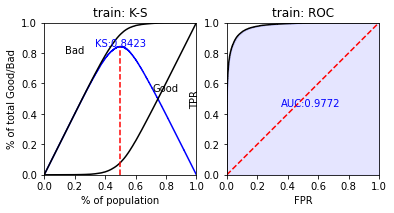

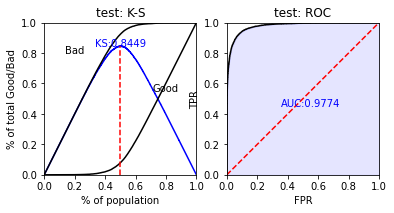

In [14]:
train_perf = sc.perf_eva(y_train, train_pred, title = "train")
test_perf = sc.perf_eva(y_test, test_pred, title = "test")

In [15]:
card = sc.scorecard(bins, lr, X_train.columns)
# credit score
train_score = sc.scorecard_ply(train, card, print_step=0)
test_score = sc.scorecard_ply(test, card, print_step=0)

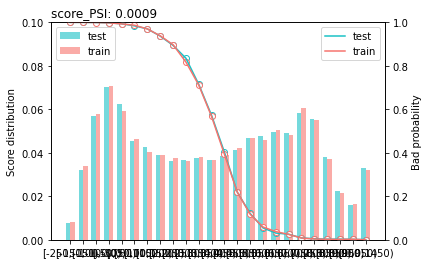

{'psi':   variable       PSI
 0    score  0.000878,
 'pic': {'score': <Figure size 432x288 with 2 Axes>}}

In [16]:
# psi
sc.perf_psi(
  score = {'train':train_score, 'test':test_score},
  label = {'train':y_train, 'test':y_test}
)

In [17]:
max_train = train_score.max()[0]
min_train = train_score.min()[0]
max_test = test_score.max()[0]
min_test = test_score.min()[0]

range_size = 850 - 300

normalized_train_score = ((train_score - min_train)/(max_train - min_train))
normalized_test_score = ((test_score - min_test)/(max_test - min_test))
normalized_train_score = 300 + (range_size * normalized_train_score)
normalized_test_score = 300 + (range_size * normalized_test_score)

In [28]:
normalized_train_score = np.array(normalized_train_score)
normalized_test_score = np.array(normalized_test_score)

In [29]:
print("Target " + str("Credit scoring") + "\n")
print("Train RMSE - ", rmse(train_target.ravel(), normalized_train_score.ravel()))
print("Test RMSE - ", rmse(test_target.ravel(), normalized_test_score.ravel()))
print("\n")
print("Train Accuracy - ", accuracy(train_target.ravel(), normalized_train_score.ravel()))
print("Test Accuracy - ", accuracy(test_target.ravel(), normalized_test_score.ravel()))
print("\n")
print("Train R squared - ", r2_score(train_target.ravel(), normalized_train_score.ravel()))
print("Test R squared - ", r2_score(test_target.ravel(), normalized_test_score.ravel()))

Target Credit scoring

Train RMSE -  253.47264587610272
Test RMSE -  256.0731595997534


Train Accuracy -  0.009257142857142858
Test Accuracy -  0.0087


Train R squared -  -3.5822963518782
Test R squared -  -3.6634174182111243


## 6.2 My own approach to credit scoring

In [30]:
df = pd.read_csv('subset_data.csv/part-00000-03fb537b-9382-4a5b-bac8-26d245ab88ab-c000.csv')

features = df[df.columns.difference(['y'])]
target = df.y

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=test_size, random_state=12345)

In [31]:
# median_values = X_train.median()
# X_train = X_train.fillna(median_values)
# X_test = X_test.fillna(median_values)

In [32]:
binary_y_train = (y_train.ravel() >= 600).astype(int)
binary_y_test = (y_test.ravel() >= 600).astype(int)

In [33]:
X_train.head()

,x003,x005,x014,x036,x043,x044,x055,x056,x057,x059,...,x243,x245,x272,x274,x275,x276,x281,x287,x293,x296
82494,28.0,196.0,7,1,14056,25000.0,0,0,0.1731,1,...,0,1,0.2841,0,NaN,0,180153,1.0,0.6303,40401
16315,NaN,NaN,0,4,0,NaN,0,0,NaN,0,...,0,0,NaN,0,NaN,0,0,NaN,NaN,0
82824,NaN,453.0,3,0,0,24600.0,0,0,NaN,0,...,0,1,0.1040,6890,0.5604,0,0,9.0,NaN,0
58259,19.0,126.0,1,5,-24,600.0,0,2,1.0533,2,...,924,1,0.2374,1229,1.0199,2,1713,1.0,0.2210,1713
5464,NaN,6.0,0,5,0,300.0,0,2,NaN,2,...,0,1,1.7066,1024,1.7066,0,0,NaN,NaN,0


## 6.2.1 WOE and IV based selection

In [34]:
target_600 = (target.ravel() >= 600).astype(int)
target_620 = (target.ravel() >= 620).astype(int)
new_target = (target.ravel() >= 600).astype(int)

The below package is a python package, I wrote to calculate WOE and IV. It also does voting based feature selection.

In [35]:
from xverse.transformer import WOE

In [41]:
woe = WOE(mono_force_bins=4)

In [42]:
woe.fit(features, new_target)

WOE(exclude_features=None, feature_names='all', mono_cardinality_cutoff=5,
    mono_custom_binning={'x003': array([  0.,   3.,   8.,  24., 704.]),
                         'x005': array([  0.,  87., 150., 246., 827.]),
                         'x014': array([ 0.,  2.,  7., 68.]),
                         'x036': array([ 0.,  1.,  2.,  5., 47.]),
                         'x043': array([-5.003000e+04,  0.000000e+00,  3.000000e+02,  1.038225e+04,
        4.885410e+06]),
                         'x044': array([0.0e+00, 1.0e+03, 6.0e+03, 2.0e...
              'x293': {Interval(-0.001, 0.641, closed='right'): 1.033247111797214,
                       Interval(0.641, 0.86, closed='right'): 0.6586194724744547,
                       Interval(0.86, 0.997, closed='right'): 0.11072504126639764,
                       Interval(0.997, 18.4, closed='right'): -0.9889857686135545,
                       'NA': -0.18807912486870207},
              'x296': {Interval(-0.001, 12956.0, closed='right'): -0.2

In [43]:
woe.iv_df

,Variable_Name,Information_Value
4,x043,2.716081
17,x236,2.695207
5,x044,2.560128
8,x057,2.198132
10,x075,2.069984
18,x239,1.841093
1,x005,1.693916
9,x059,1.668916
16,x234,1.311136
24,x275,1.289986


In [44]:
woe.woe_df

,Variable_Name,Category,Count,Event,Non_Event,Event_Rate,Non_Event_Rate,Event_Distribution,Non_Event_Distribution,WOE,Information_Value
0,x003,"(-0.001, 3.0]",23596,14070,9526,0.596288,0.403712,0.282071,0.190068,0.394780,0.823809
1,x003,"(3.0, 8.0]",17866,9850,8016,0.551327,0.448673,0.197470,0.159939,0.210792,0.823809
2,x003,"(8.0, 24.0]",17690,11108,6582,0.627925,0.372075,0.222690,0.131327,0.528087,0.823809
3,x003,"(24.0, 704.0]",19416,12387,7029,0.637979,0.362021,0.248331,0.140246,0.571363,0.823809
4,x003,NA,21432,2466,18966,0.115062,0.884938,0.049438,0.378419,-2.035290,0.823809
...,...,...,...,...,...,...,...,...,...,...,...
93,x293,"(0.86, 0.997]",12223,6435,5788,0.526466,0.473534,0.129007,0.115485,0.110725,0.301255
94,x293,"(0.997, 18.4]",12207,3298,8909,0.270173,0.729827,0.066117,0.177757,-0.988986,0.301255
95,x293,NA,51133,23109,28024,0.451939,0.548061,0.463283,0.559149,-0.188079,0.301255
96,x296,"(-0.001, 12956.0]",75001,33300,41701,0.443994,0.556006,0.667589,0.832040,-0.220208,0.148475


In [45]:
woe_train = woe.transform(X_train)
woe_test = woe.transform(X_test)

In [46]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(woe_train, binary_y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [47]:
clf.coef_

array([[ 0.1556628 ,  0.32019355,  0.26203329,  0.98731151, -0.14530097,
         0.29963661,  5.41907523,  0.49720883,  0.44945927,  0.24218115,
         0.39743728,  0.44096903,  2.77127647,  0.31480616,  0.49841266,
         0.82529682, -0.03960325,  0.30379055, -0.18565301, -0.28476386,
         0.56286633,  0.21852485,  0.4014277 ,  0.08254341,  0.53081915,
         0.45480039,  0.54760703,  0.14749367,  0.62153572,  0.19301024]])

In [48]:
clf.intercept_

array([0.47783775])

In [49]:
pred_train = clf.predict(woe_train)
pred_test = clf.predict(woe_test)

In [50]:
from sklearn.metrics import accuracy_score

accuracy_score(binary_y_train, pred_train),  accuracy_score(binary_y_test, pred_test)

(0.9203285714285714, 0.9181)

Now, I will use a series of equation to calculate the credit score

Score_i= (βi × WoE_i + α/n) × Factor + Offset/n  
Where:  
βi — logistic regression coefficient for the variable Xi  
α — logistic regression intercept  
WoE — Weight of Evidence value for variable Xi  
n — number of independent variable Xi in the model  
Factor, Offset — known as scaling parameter, where  
Factor = pdo/ln(2)  
Offset = Target Score — (Factor × ln(Target Odds))  

In [51]:
Factor = 20/np.log(2)
Offset = 600- Factor *np.log(50)

In [53]:
Factor, Offset

(28.85390081777927, 487.1228762045055)

In [54]:
n = woe_train.shape[1]

In [80]:
coefficient_df = pd.DataFrame(clf.coef_, columns=woe_train.columns)

In [81]:
score_table = woe.woe_df

In [96]:
final_score = pd.DataFrame(columns=list(score_table.columns).extend('score'))
for i in np.unique(score_table['Variable_Name']):
    subset_score = score_table[score_table['Variable_Name'] == i]
    temp_coef = coefficient_df[i][0]
    alpha = clf.intercept_/n
    subset_score['score'] = subset_score['WOE'].apply(lambda x: ((temp_coef * x + alpha) * Factor + (Offset/n))[0])
    final_score = final_score.append(subset_score, ignore_index=True)

In [108]:
final_score = final_score['Variable_Name', 'WOE', 'score']

In [117]:
score_mapping = {}
for i in np.unique(final_score.Variable_Name):
    subset_score = final_score[final_score["Variable_Name"] == i]
    score_mapping[i] = dict(zip(subset_score['WOE'], subset_score['score']))

In [127]:
def score_apply(df, score_mapping):
    
    tempX = df.copy(deep=True)
    for i in tempX.columns:
        tempX[i] = tempX[i].replace(score_mapping[i])   
    return tempX

In [130]:
output_train = score_apply(woe_train, score_mapping)
output_train = output_train.sum(axis=1)

In [131]:
output_test = score_apply(woe_test, score_mapping)
output_test = output_test.sum(axis=1)

In [147]:
output_train.max(), output_train.min()

(735.7438505960877, 79.40485072091212)

In [143]:
max_train = output_train.max()
min_train = output_train.min()
max_test = output_test.max()
min_test = output_test.min()

range_size = 850 - 300

normalized_train_score = ((output_train - min_train)/(max_train - min_train))
normalized_test_score = ((output_test - min_test)/(max_test - min_test))
normalized_train_score = 300 + (range_size * normalized_train_score)
normalized_test_score = 300 + (range_size * normalized_test_score)

normalized_train_score = np.array(normalized_train_score)
normalized_test_score = np.array(normalized_test_score)

In [146]:
normalized_train_score.max(), normalized_train_score.min()

(850.0, 300.0)

In [148]:
print("Target " + str("Credit scoring") + "\n")
print("Train RMSE - ", rmse(y_train.ravel(), output_train.ravel()))
print("Test RMSE - ", rmse(y_test.ravel(), output_test.ravel()))
print("\n")
print("Train Accuracy - ", accuracy(y_train.ravel(), output_train.ravel()))
print("Test Accuracy - ", accuracy(y_test.ravel(), output_test.ravel()))
print("\n")
print("Train R squared - ", r2_score(y_train.ravel(), output_train.ravel()))
print("Test R squared - ", r2_score(y_test.ravel(), output_test.ravel()))

Target Credit scoring

Train RMSE -  139.90187298948464
Test RMSE -  139.7626445364412


Train Accuracy -  0.0031857142857142856
Test Accuracy -  0.0034333333333333334


Train R squared -  -0.39170800650597615
Test R squared -  -0.39908480490148457


In [134]:
def make_confusion_matrix_chart(cf_matrix_train, cf_matrix_test):
    
    list_values = ['Below 600', 'Above 600']
    plt.figure(1, figsize=(10,5))

    plt.subplot(121)
    sns.heatmap(cf_matrix_train, annot=True, yticklabels=list_values, 
                                xticklabels=list_values, fmt='g')
    plt.ylabel("Actual")
    plt.xlabel("Pred")
    plt.ylim([0,2])
    plt.title('Train data')

    plt.subplot(122)
    sns.heatmap(cf_matrix_test, annot=True, yticklabels=list_values, 
                                xticklabels=list_values, fmt='g')
    plt.ylabel("Actual")
    plt.xlabel("Pred")
    plt.ylim([0,2])
    plt.tight_layout()
    plt.title('Test data')

    plt.tight_layout()
    return None

In [136]:
from sklearn.metrics import confusion_matrix

cf_matrix_train = confusion_matrix(binary_y_train, pred_train)
cf_matrix_test = confusion_matrix(binary_y_test, pred_test)

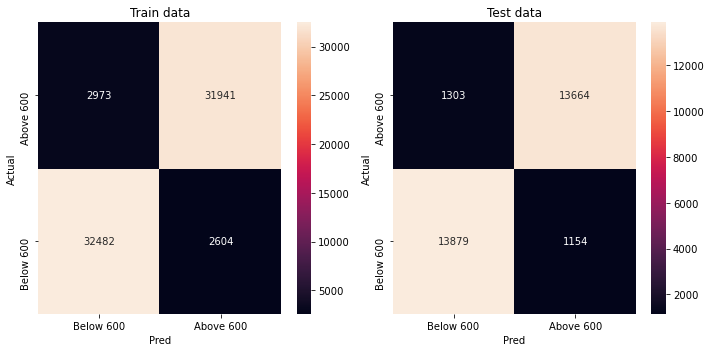

In [137]:
make_confusion_matrix_chart(cf_matrix_train, cf_matrix_test)

So far based on my analysis, I have concluded the following. Random Forest python model does a better job on RMSE metric and overall the model is best I have found. However, the model is overfitting on training dataset. I can optimize the hyperparameters of the Random Forest model to get the best hyperparameters without overfitting on training dataset.

One another interesting approach, I found with credit scoring is that the model is giving me a better accuracy when I use a binary classication approach on target column as shown above. So, the scores above 600 are 1 and scores below 600 are 0. With this approach the model is easily able to give me a accuracy score of 91%. So maybe, I can extend this approach to build a classification model first and then use that model output to fit two random forest model on the smaller dataset and that way I can improve the overall model accuracy. This will be my next approach.

# 7. Final approach

In [3]:
df = pd.read_csv('subset_data.csv/part-00000-03fb537b-9382-4a5b-bac8-26d245ab88ab-c000.csv')

In [4]:
features = df[df.columns.difference(['y'])]
target = df['y']

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=12345)

In [6]:
# binary target for binary model
binary_y_train = (y_train >= 600).astype(int)
binary_y_test = (y_test >= 600).astype(int)

In [7]:
median_values = X_train.median()
X_train = X_train.fillna(median_values)
X_test = X_test.fillna(median_values)

## 7.1 Build the binary model

In [8]:
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

#classification_model = VotingClassifier(estimators=[('xg', clf1), ('gb', clf2), ('rf', clf3)], voting='soft')
#classification_model = xgb.XGBClassifier()
classification_model = GradientBoostingClassifier()
#classification_model = RandomForestClassifier()

classification_model.fit(X_train, binary_y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [9]:
pred_class_train = classification_model.predict(X_train)
pred_class_test = classification_model.predict(X_test)

## 7.2 Evaluate the binary model

Train accuracy -  0.9356571428571429
Test accuracy -  0.9328333333333333


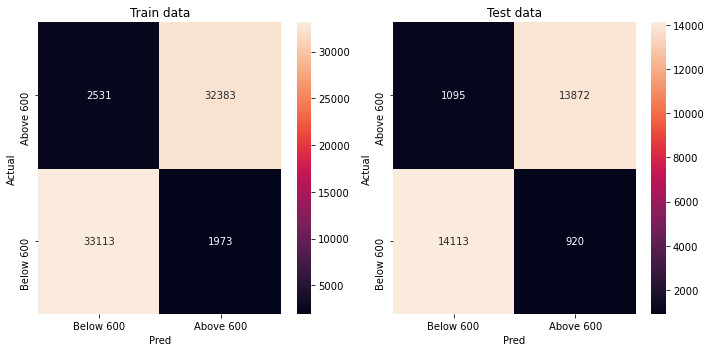

In [10]:
from sklearn.metrics import confusion_matrix, accuracy_score

def make_confusion_matrix_chart(cf_matrix_train, cf_matrix_test):
    
    list_values = ['Below 600', 'Above 600']
    plt.figure(1, figsize=(10,5))

    plt.subplot(121)
    sns.heatmap(cf_matrix_train, annot=True, yticklabels=list_values, 
                                xticklabels=list_values, fmt='g')
    plt.ylabel("Actual")
    plt.xlabel("Pred")
    plt.ylim([0,2])
    plt.title('Train data')

    plt.subplot(122)
    sns.heatmap(cf_matrix_test, annot=True, yticklabels=list_values, 
                                xticklabels=list_values, fmt='g')
    plt.ylabel("Actual")
    plt.xlabel("Pred")
    plt.ylim([0,2])
    plt.tight_layout()
    plt.title('Test data')

    plt.tight_layout()
    return None

cf_matrix_train = confusion_matrix(binary_y_train, pred_class_train)
cf_matrix_test = confusion_matrix(binary_y_test, pred_class_test)

make_confusion_matrix_chart(cf_matrix_train, cf_matrix_test)
print("Train accuracy - ", accuracy_score(binary_y_train, pred_class_train))
print("Test accuracy - ", accuracy_score(binary_y_test, pred_class_test))

Ok, now we have a good classifier model for the first step. Let us build 2 regression models - One for credit score below 600 and one above. 

## 7.3 Helper function to build regression model

In [12]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt 

# define model evaluation rmse function
def rmse(y, pred):
    rmse = sqrt(mean_squared_error(y, pred))
    return rmse

# define accuracy evaluation function
def accuracy(y, pred):
    accuracy = (np.abs(y - pred) <= 3).astype(int)
    return np.sum(accuracy)/len(accuracy)

In [81]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb

def model_builder(df, min_value, max_value, model_type='rf'):
    
    #create features and targets dataset
    features = df[df.columns.difference(['y'])]
    target = df['y']
    
    #train test split and imputation
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=12345)
    median_values = X_train.median()
    X_train = X_train.fillna(median_values)
    X_test = X_test.fillna(median_values)
    
    # model initializer
    if model_type == 'xg':
        reg = xgb.XGBRegressor()
        model_name = 'XG Boosting'
    elif model_type == 'gb':
        reg = GradientBoostingRegressor()
        model_name = 'Gradient Boosting'
    else:
        reg = RandomForestRegressor()
        model_name = 'Random Forest'
    
    # fit the model
    reg.fit(X_train, y_train)
    
    #model predictions
    pred_train = reg.predict(X_train)
    pred_test = reg.predict(X_test)
    
    pred_train[pred_train > max_value] = max_value
    pred_test[pred_test > max_value] = max_value
    pred_train[pred_train < min_value] = min_value
    pred_test[pred_test < min_value] = min_value
    
    rmse_train = rmse(y_train, pred_train)
    rmse_test = rmse(y_test, pred_test)
    acc_train = accuracy(y_train, pred_train)
    acc_test = accuracy(y_test, pred_test)
    r2_train = r2_score(y_train, pred_train)
    r2_test = r2_score(y_test, pred_test)
    
    print("Model - " + str(model_name) + "\n")
    print("Train RMSE - ", rmse_train)
    print("Test RMSE - ", rmse_test)
    print("\n")
    print("Train Accuracy - ", acc_train)
    print("Test Accuracy - ", acc_test)
    print("\n")
    print("Train R squared - ", r2_train)
    print("Test R squared - ", r2_test)
    
    return X_train, X_test, y_train, y_test, pred_train, pred_test

## 7.4 Split to two dataframes - Below 600 and above 600

In [82]:
below_600_df = df[df['y'] < 600]
above_600_df = df[df['y'] >= 600]

In [83]:
len(below_600_df), len(above_600_df)

(50119, 49881)

## 7.4 Build regression model - Below 600

In [84]:
X_train, X_test, y_train, y_test, pred_train, pred_test = model_builder(below_600_df, 300, 600, model_type='rf')

Model - Random Forest

Train RMSE -  10.316885133162707
Test RMSE -  27.568111703806885


Train Accuracy -  0.35438816520822053
Test Accuracy -  0.1681298217611067


Train R squared -  0.9576178618448056
Test R squared -  0.6986379772214959


In [85]:
pred_train.min(), pred_train.max(), pred_test.min(), pred_test.max()

(300.1, 596.97, 302.33, 591.69)

In [86]:
X_train, X_test, y_train, y_test, pred_train, pred_test = model_builder(below_600_df, 300, 600, model_type='gb')

Model - Gradient Boosting

Train RMSE -  28.18004386018231
Test RMSE -  28.866788683544485


Train Accuracy -  0.11603910725992646
Test Accuracy -  0.11392657621707901


Train R squared -  0.6837948041741135
Test R squared -  0.669576118466056


In [87]:
X_train, X_test, y_train, y_test, pred_train, pred_test = model_builder(below_600_df, 300, 600, model_type='xg')

Model - XG Boosting

Train RMSE -  20.451358041582008
Test RMSE -  27.320160374267974


Train Accuracy -  0.17581164666647664
Test Accuracy -  0.14804469273743018


Train R squared -  0.8334556221900016
Test R squared -  0.7040345803777855


## 7.5 Build regression model - Above 600

In [88]:
X_train, X_test, y_train, y_test, pred_train, pred_test = model_builder(above_600_df, 600, 850, model_type='rf')

Model - Random Forest

Train RMSE -  9.860865586583905
Test RMSE -  25.89045544041602


Train Accuracy -  0.33236911444609923
Test Accuracy -  0.1367190110257267


Train R squared -  0.9817893919466536
Test R squared -  0.874514753829721


In [89]:
X_train, X_test, y_train, y_test, pred_train, pred_test = model_builder(above_600_df, 600, 850, model_type='gb')

Model - Gradient Boosting

Train RMSE -  27.680111968883466
Test RMSE -  28.030740660648167


Train Accuracy -  0.11046511627906977
Test Accuracy -  0.10477781490143669


Train R squared -  0.8565072184445832
Test R squared -  0.8529102420580634


In [90]:
X_train, X_test, y_train, y_test, pred_train, pred_test = model_builder(above_600_df, 600, 850, model_type='xg')

Model - XG Boosting

Train RMSE -  20.45615322646164
Test RMSE -  25.920328863785187


Train Accuracy -  0.15700538435101385
Test Accuracy -  0.12415636485131974


Train R squared -  0.9216313608519332
Test R squared -  0.8742250071639993


# 7.3 Bayesian Hyperparameter tuning - for classification model

In [15]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [16]:
param_space ={'max_depth': hp.choice('max_depth', range(1,20)),
    'max_features': hp.choice('max_features', range(2,30)),
    'n_estimators': hp.choice('n_estimators', range(100,500)),
    'criterion': hp.choice('criterion', ["gini", "entropy"]),
    'min_samples_split' : hp.choice('min_samples_split', [2, 5, 20,50])}

In [25]:
from sklearn.model_selection import cross_val_score

def acc_model(params):
    clf = RandomForestClassifier(**params)
    return cross_val_score(clf, X_train[:20000], binary_y_train[:20000]).mean()

In [26]:
best = 0

def f(params):
    global best
    acc = acc_model(params)
    if acc > best:
        best = acc
    print ('new best:', best, params)
    return {'loss': -acc, 'status': STATUS_OK}

In [27]:
trials = Trials()
best = fmin(f, param_space, algo=tpe.suggest, max_evals=10, trials=trials)
print ('best:')
print (best)

new best:                                             
0.9214                                                
{'criterion': 'gini', 'max_depth': 8, 'max_features': 13, 'min_samples_split': 20, 'n_estimators': 379}
new best:                                                            
0.9214                                                               
{'criterion': 'entropy', 'max_depth': 4, 'max_features': 2, 'min_samples_split': 50, 'n_estimators': 271}
new best:                                                            
0.9305                                                               
{'criterion': 'gini', 'max_depth': 15, 'max_features': 2, 'min_samples_split': 2, 'n_estimators': 190}
new best:                                                            
0.9305                                                               
{'criterion': 'entropy', 'max_depth': 10, 'max_features': 24, 'min_samples_split': 2, 'n_estimators': 251}
new best:                                         

In [28]:
best

{'criterion': 1,
 'max_depth': 17,
 'max_features': 6,
 'min_samples_split': 1,
 'n_estimators': 149}

In [47]:
clf = RandomForestClassifier(criterion='gini', max_depth=17, max_features=6, n_estimators=149, min_samples_split=20)

In [48]:
clf.fit(X_train, binary_y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=17, max_features=6,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=149,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [49]:
pred_class_train = classification_model.predict(X_train)
pred_class_test = classification_model.predict(X_test)

Train accuracy -  0.9996714285714285
Test accuracy -  0.9347666666666666


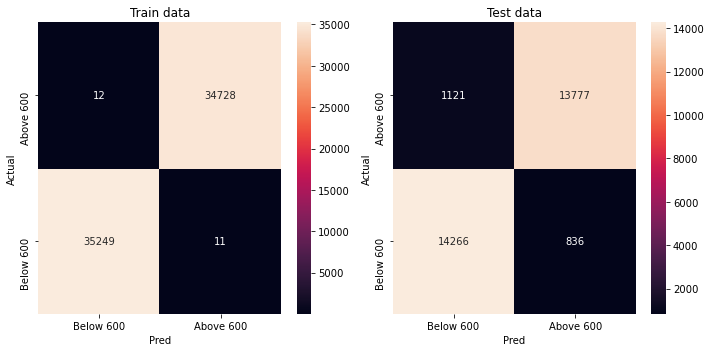

In [50]:
cf_matrix_train = confusion_matrix(binary_y_train, pred_class_train)
cf_matrix_test = confusion_matrix(binary_y_test, pred_class_test)

make_confusion_matrix_chart(cf_matrix_train, cf_matrix_test)
print("Train accuracy - ", accuracy_score(binary_y_train, pred_class_train))
print("Test accuracy - ", accuracy_score(binary_y_test, pred_class_test))